In [1]:
import os
import sys

path = ['..', 'CToxPred']
src_dir = os.path.abspath(os.path.join(*path))
if src_dir not in sys.path:
    sys.path.append(src_dir)

In [2]:
import joblib
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch

from pairwise_correlation import CorrelationThreshold
from utils import compute_fingerprint_features, compute_descriptor_features, compute_metrics
from hERG_model import hERGClassifier
from nav15_model import Nav15Classifier
from cav12_model import Cav12Classifier

### Load data

In [3]:
## hERG
eval_herg_set_60 = pd.read_csv("../data/raw/hERG/eval_set_herg_60.csv")
eval_herg_set_70 = pd.read_csv("../data/raw/hERG/eval_set_herg_70.csv")
## Nav1.5
eval_nav_set_60 = pd.read_csv("../data/raw/Nav1.5/eval_set_nav_60.csv")
eval_nav_set_70 = pd.read_csv("../data/raw/Nav1.5/eval_set_nav_70.csv")
## Cav1.2
eval_cav_set_60 = pd.read_csv("../data/raw/Cav1.2/eval_set_cav_60.csv")
eval_cav_set_70 = pd.read_csv("../data/raw/Cav1.2/eval_set_cav_70.csv")

### Assign labels

In [4]:
## Label the sets
eval_herg_set_60['Label'] = np.where(eval_herg_set_60['pIC50'] >= 5, 1, 0)
eval_herg_set_70['Label'] = np.where(eval_herg_set_70['pIC50'] >= 5, 1, 0)
## Label the sets
eval_nav_set_60['Label'] = np.where(eval_nav_set_60['pIC50'] >= 5, 1, 0)
eval_nav_set_70['Label'] = np.where(eval_nav_set_70['pIC50'] >= 5, 1, 0)
## Label the sets
eval_cav_set_60['Label'] = np.where(eval_cav_set_60['pIC50'] >= 5, 1, 0)
eval_cav_set_70['Label'] = np.where(eval_cav_set_70['pIC50'] >= 5, 1, 0)

### Load models

In [5]:
def _generate_predictions(smiles_list: List[str]) -> pd.DataFrame:
    """
    Generates predictions for hERG, Nav1.5, and Cav1.2 targets based on the provided list of SMILES.

    This function processes the input SMILES list and computes fingerprint and descriptor features for each compound.
    Then, it loads pre-trained models for hERG, Nav1.5, and Cav1.2 targets, and predicts the activity of each compound
    for these targets using the respective models. The predictions are saved to a CSV file named 'predictions.csv'
    with columns: 'SMILES', 'hERG', 'Nav1.5', and 'Cav1.2'. The 'hERG', 'Nav1.5', and 'Cav1.2' columns contain the
    binary predictions (0 or 1) for each target, representing non-toxic (negative class) or toxic (positive class)
    compounds, respectively.

    Parameters:
        smiles_list: List[str] 
            A list containing SMILES strings of chemical compounds.

    Returns:
        pd.DataFrame: 
            A DataFrame with 4 columns {'SMILES', 'hERG', 'Nav1.5', Cav1.2'} containing the predictions for each target 
            of the input SMILES strings .
    """
    # Compute features
    print('>>>>>>> Calculate Features <<<<<<<')
    fingerprints = compute_fingerprint_features(smiles_list)
    descriptors = compute_descriptor_features(smiles_list)
    # Process hERG
    print('>>>>>>> Predict hERG <<<<<<<')
    hERG_fingerprints = fingerprints
    ## Load model
    hERG_predictor = hERGClassifier(1905, 2)
    path = ['..','CToxPred', 'models', 'model_weights', 'hERG',
            '_herg_checkpoint.model']
    hERG_predictor.load(os.path.join(*path))
    device = torch.device('cpu')
    hERG_predictions = hERG_predictor(
        torch.from_numpy(hERG_fingerprints).float().to(device)).argmax(1).cpu()

    # Process Nav1.5
    print('>>>>>>> Predict Nav1.5 <<<<<<<')
    nav15_fingerprints = fingerprints
    nav15_descriptors = descriptors
    ## Load preprocessing pipeline
    path = ['..','CToxPred', 'models', 'decriptors_preprocessing', 'Nav1.5',
            'nav_descriptors_preprocessing_pipeline.sav']
    descriptors_transformation_pipeline = joblib.load(os.path.join(*path))
    nav15_descriptors = descriptors_transformation_pipeline.transform(
        nav15_descriptors)
    nav15_features = np.concatenate((nav15_fingerprints, nav15_descriptors),
                                    axis=1)
    ## Load model
    nav15_predictor = Nav15Classifier(2454, 2)
    path = ['..', 'CToxPred', 'models', 'model_weights', 'Nav1.5',
            '_nav15_checkpoint.model']
    nav15_predictor.load(os.path.join(*path))
    nav15_predictions = nav15_predictor(
        torch.from_numpy(nav15_features).float().to(device)).argmax(1).cpu()

    # Process Cav1.2
    print('>>>>>>> Predict Cav1.2 <<<<<<<')
    cav12_fingerprints = fingerprints
    cav12_descriptors = descriptors
    ## Load preprocessing pipeline
    path = ['..', 'CToxPred', 'models', 'decriptors_preprocessing', 'Cav1.2',
            'cav_descriptors_preprocessing_pipeline.sav']
    descriptors_transformation_pipeline = joblib.load(os.path.join(*path))
    cav12_descriptors = descriptors_transformation_pipeline.transform(
        cav12_descriptors)
    cav12_features = np.concatenate((cav12_fingerprints, cav12_descriptors),
                                    axis=1)
    ## Load model
    cav12_predictor = Cav12Classifier(2586, 2)
    path = ['..', 'CToxPred', 'models', 'model_weights', 'Cav1.2',
            '_cav12_checkpoint.model']
    cav12_predictor.load(os.path.join(*path))
    cav12_predictions = cav12_predictor(
        torch.from_numpy(cav12_features).float().to(device)).argmax(1).cpu()

    # Generate output
    results = pd.DataFrame({'SMILES': smiles_list, 'hERG': hERG_predictions,
                            'Nav1.5': nav15_predictions,
                            'Cav1.2': cav12_predictions})
    return results

### Initialize confusion matrix

In [6]:
def draw_confusion_matrix(ground_truth, predicted):
    ## Compute confusion matrix
    matrix = confusion_matrix(ground_truth, predicted)
    percentages = (matrix.T/matrix.sum(axis=1)).T
    ## Set cell format
    flattened_counts = [value for value in matrix.flatten()]
    flattened_percentages = ["{0:.2%}".format(value) for value in percentages.flatten()]
    labels = [f"{percentage}\n{value}" for value, percentage in 
                                      zip(flattened_counts,flattened_percentages)]
    labels = np.asarray(labels).reshape(matrix.shape[0],matrix.shape[0])
    ## create dataframe to set x/y-axis labels with focus on percentage
    percentDataframe = pd.DataFrame(percentages*100, 
                           columns = ['Non-blocker','Blocker'],
                           index = ['Non-blocker', 'Blocker'])
    ## Plot
    plt.style.use(['seaborn-white', 'seaborn-paper'])
    sns.set_context('paper', font_scale=1.0)
    width = 7
    height = width / 1.6
    plt.figure(figsize=(width, height))
    ax = plt.axes()
    
    sns.heatmap(percentDataframe, annot = labels, fmt='',cmap= 'Blues', ax=ax, vmin=0, vmax=100, cbar_kws={'label': 'Accuracy'})
    ax.yaxis.set_tick_params(rotation=0)
    ax.set(xlabel='Predicted label', ylabel='True label')
    ax.title.set_text('Accuracy = {0:.1%}'.format(sum(1 for x,y in zip(ground_truth,predicted) if x == y) / len(ground_truth)))
    plt.show()

## Make cardiotoxicity predictions

In [7]:
predictions = _generate_predictions(eval_herg_set_60['SMILES'])

>>>>>>> Calculate Features <<<<<<<


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:24<00:00, 10.41it/s]


>>>>>>> Predict hERG <<<<<<<
>>>>>>> Predict Nav1.5 <<<<<<<
>>>>>>> Predict Cav1.2 <<<<<<<


In [8]:
predictions

,SMILES,hERG,Nav1.5,Cav1.2
0,Cn1ccc(C[N+]2=CC(c3cccc(C(F)(F)F)c3)C=N2)n1,1,0,1
1,CC(C)(C)OC(=O)N1CCN(c2nc3c([N+](=O)[O-])c(Br)c...,1,1,1
2,Fc1cccc(Oc2cc(C(F)(F)F)nc(N3CCc4nc[nH]c4C3)n2)c1,1,1,0
3,Cn1nccc1Cc1cn(-c2ccc(F)c(Cl)c2)nn1,1,0,0
4,CNC[C@@H](c1ccc(Cl)c(Cl)c1)[C@@H](OC)c1cccc(NS...,0,1,1
...,...,...,...,...
245,Cc1ccccc1N1N/C(=c2/c(-c3ccc(F)cc3)nn3c2=NC[C@@...,1,0,0
246,C/C(NNC(=O)c1cccc(S(=O)(=O)N2CCOCC2)c1)=C1/C=C...,0,1,0
247,O=C1C=C/C(=c2/ccc3n[nH]/c(=C4/C=NC=C(O[C@H]5CN...,1,1,1
248,CC(C)[C@]1(C)CC(=O)N(Cc2cc(F)cc(C(=O)N[C@@H](C...,1,0,1


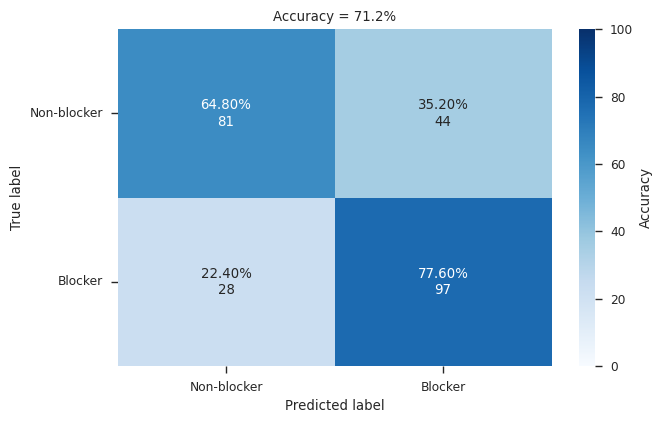

In [9]:
draw_confusion_matrix(eval_herg_set_60['Label'],predictions['hERG'])

In [10]:
compute_metrics(eval_herg_set_60['Label'],predictions['hERG'])

Binary classification performace metrics:
[[81 44]
 [28 97]]
TP, FN, TN, FP
97, 28, 81, 44
AC: 0.712
f1: 0.729
SN: 0.776
SP: 0.648
CCR: 0.712
MCC: 0.428
